# DSAI Mini-project
## HDB Resale Price Analysis 

The dataset that we will use is in regards to the resale pricing of HDBs in Singapore, contain details such as the type of HDB, size and etc. Our main goal for this study is to create an Regression model that is able to accurately predict the resale price of the houses, providing people with a tool that is able to estimate the worth of their home when they are considering to sell.

The data was gathered from https://data.gov.sg/collections/189/view.


In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import plotly.express as px


sns.set_style('darkgrid')

Due to the multiple datasets chunked into different yearly intervals, we are required to read all of them and concat them into a single dataset before analysing

In [5]:
dfs = [] 
for file in os.listdir('./datasets'):
    dfs.append(pd.read_csv(f"./datasets/{file}"))

df = pd.concat(dfs)
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,NaN
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,NaN
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0,NaN
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0,NaN
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0,NaN


### Exploratory Data Analysis
First we will conduct EDA on our dataset try to understand what we are working with, as well as clean up our dataset

####  Understanding our data

Here are some summary details and statistics of our dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 660656 entries, 0 to 201648
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                660656 non-null  object 
 1   town                 660656 non-null  object 
 2   flat_type            660656 non-null  object 
 3   block                660656 non-null  object 
 4   street_name          660656 non-null  object 
 5   storey_range         660656 non-null  object 
 6   floor_area_sqm       660656 non-null  float64
 7   flat_model           660656 non-null  object 
 8   lease_commence_date  660656 non-null  int64  
 9   resale_price         660656 non-null  float64
 10  remaining_lease      238802 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 60.5+ MB


We see that our dataset consists of a total of 11 columns, and based on research online these are what each of the columns represent


| Feature | Description |
|---------|------------|
| **month** (object) | The month in which the resale transaction took place, formatted as "YYYY-MM". |
| **town** (object) | The town or estate in Singapore where the HDB flat is located (e.g., Ang Mo Kio, Bedok, Jurong West). |
| **flat_type** (object) | The type of HDB flat based on the number of rooms, such as "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", etc. |
| **block** (object) | The block number of the HDB flat. |
| **street_name** (object) | The name of the street where the block is located. |
| **storey_range** (object) | The range of floors where the unit is located, typically in ranges like "01 TO 03", "04 TO 06", etc. |
| **floor_area_sqm** (float64) | The size of the flat in square meters (sqm). |
| **flat_model** (object) | The specific model of the flat (e.g., "Improved", "New Generation", "Model A", "Maisonette"), indicating the design and layout. |
| **lease_commence_date** (int64) | The year when the lease for the flat started. |
| **resale_price** (float64) | The transaction price of the flat in Singapore dollars (SGD). |
| **remaining_lease** (object) | The remaining lease period of the flat at the time of the transaction (e.g., "85 years 2 months"). This column has many missing values, possibly due to it not being recorded for older transactions. |

In [7]:
df.shape

(660656, 11)

Overall there are up to 660,656 entries in our dataset with 11 columns. 

In [8]:
# Disable scientific notation 
pd.set_option('display.float_format', '{:,.7f}'.format)  # This will show up to 10 decimal places7
df.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,"660,656.0000000","660,656.0000000","660,656.0000000"
mean,96.6914270,"1,990.7894986","374,420.5161277"
std,25.0038018,11.6739151,"174,498.6215847"
min,28.0000000,"1,966.0000000","28,000.0000000"
25%,74.0000000,"1,983.0000000","245,000.0000000"
50%,95.0000000,"1,988.0000000","348,000.0000000"
75%,113.0000000,"1,999.0000000","465,000.0000000"
max,366.7000000,"2,021.0000000","1,600,000.0000000"


Observing the numerical features of our dataset, we see that:
- The floor area ranges from 28 sqm to 366 sqm, with a mean of 96 sqm. This suggests the presence of outliers, as the third quartile (Q3) reaches only 113 sqm, while the maximum value extends significantly beyond that to 366 sqm. Also this will likely play a big part in our prediction as it is known that a bigger space tends to lead to higher housing price 

- For the lease commence date it only spans from 1966 to 2021, and there are no issues or outliers as it is a relatively controlled quantitative feature

- Finally for the resale price we see that it ranges from 28,000 to 1,600,000 with a mean of 374,420. It also suggests outliers due to the third quartile reaching only 465,000 while the max extends to 1,600,000. This indicates we must be cautious when selecting and interpreting metrics, as high-value outliers may skew the analysis.

In [9]:
df.describe(include='object')

,month,town,flat_type,block,street_name,storey_range,flat_model,remaining_lease
count,660656,660656,660656,660656,660656,660656,660656,238802
unique,303,26,7,2734,578,25,21,735
top,2010-07,WOODLANDS,4 ROOM,2,YISHUN RING RD,04 TO 06,Model A,68
freq,3679,57365,262762,2726,10767,161899,202889,2328


In [10]:
print(f"""
Flat types: {', '.join(df['flat_type'].unique())}'

Flat Storey Range: {', '.join(df['storey_range'].unique())}

Flat Model: {', '.join(df['flat_model'].unique())}

""")


Flat types: 3 ROOM, 4 ROOM, 5 ROOM, EXECUTIVE, 2 ROOM, MULTI-GENERATION, 1 ROOM'

Flat Storey Range: 07 TO 09, 04 TO 06, 01 TO 03, 10 TO 12, 13 TO 15, 16 TO 18, 19 TO 21, 22 TO 24, 25 TO 27, 28 TO 30, 31 TO 33, 40 TO 42, 37 TO 39, 34 TO 36, 46 TO 48, 43 TO 45, 49 TO 51, 06 TO 10, 01 TO 05, 11 TO 15, 16 TO 20, 21 TO 25, 26 TO 30, 36 TO 40, 31 TO 35

Flat Model: Improved, New Generation, Model A, Standard, Apartment, Simplified, Model A-Maisonette, Maisonette, Multi Generation, Adjoined flat, Premium Apartment, Terrace, Improved-Maisonette, Premium Maisonette, 2-room, Model A2, Type S1, Type S2, DBSS, Premium Apartment Loft, 3Gen




As for the categorical variables, we see that 
- The month feature contains 303 unique values, despsite being labelled as month it seems to contain the year value as well. We also see that 2010-07 is the most frequent value, indicating that the most resales that occured were specifically in July of 2010
- The town feature contains 26 total towns, with woodlands being the place with the most HDBs resold. This may be quite important as different regions are known to have varying price ranges
- There are only 7 flat types, this should be an ordinal variable as usually a higher room count indicates a more expensisve home 
- There are 2734 unique housing blocks, there is likely little to no relation between this and our target feature so we might want to remove it later 
- There are 578 street names in our dataset, which can play a part in the resale price but is likely too specific and may just add more noice to our predictions. However it may be useful in feature engineering to find the distance between house to things like mrt
- Each home also has a storey range interval between 3 levels, with level 04-06 being the most resold. For this we can either take the middle of the 2 storeys or split the range to an upper and lower value
- There are 21 flat models, however these may not be too useful as they do not have a clear hierachical order. But further analysis is required
- Finally we have a remaining lease feature that we thought should only be up to 99 years  due to sg being 99 lease max, however we have 735 unique values

### Futher Data Gathering

To make our project more fruitful, we decided to add things such as:
- MRT station, with lat and long data 
- Malls with lat and long data
- Lat and long extraction for each house 

This will allow us to calculate things outside of our dataset, such as distances between each home to ammenities, nearest public space available and etc that can greatly help with the accuracy of our model and understanding of our data 

#### Tools 
- Beautiful soup for web scraping 
- One map for lat and long finding of locations

In [11]:
import requests
from bs4 import BeautifulSoup
import json
import re
from tqdm import tqdm

### MRT Station Extraction

First we will try to extract lat and long data of MRT stations in Singapore. This requires a 2 step process:
- Web scrapping for all available MRT stations in SG currently 
- Lat and long location using One Map API

We will be scrapping from wikipedia, even though it may not be the most reliable source of information it is the easiest to extract just via html elements, and since it is a Singapore page, it is unlikely to have major reliability issues.

In [23]:
url = "https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations"  # Example URL
response = requests.get(url)  # Send HTTP request

# Check if request was successful
if response.status_code == 200:
    print("Request successful!")
else:
    print("Failed to retrieve page.")

soup = BeautifulSoup(response.text, "html.parser")  # Parse HTML

Request successful!


In [10]:
tables = soup.find_all("table")  # Find all tables
print(f"Number of tables found: {len(tables)}")

Number of tables found: 23


There have been 23 tables found in the wiki, Singapore only has 6 that are official constructed. After some identification, table 2 to 8 are the correct tables we are looking for.

Below is a function that has been created by us to extract the mrt station name. If it meets any issues, it will just ignore and proceed

In [11]:
def extract_mrt(table):
    rows = table.find_all("tr")  # Get all table rows
    mrt_stations = pd.DataFrame({
        'station_name': [],
        'code': []
    })

    for row in rows:  # Print first 5 rows
        cols = row.find_all("td")  # Get table columns
        row = [col.text.strip() for col in cols]
  

        try:
            match = re.match(r'([A-Za-z]+[0-9]+)', row[0])
            if match:
                result = match.group(0)  # This gives you 'NS1'
            mrt_stations.loc[len(mrt_stations)] = [row[1], result]
        except:
            continue

    return mrt_stations

Below we extracted the north south line as a test and see that it works

In [12]:
mrt_stations = extract_mrt(tables[2])
mrt_stations.head()

,station_name,code
0,Jurong East,NS1
1,Bukit Batok,NS2
2,Bukit Gombak,NS3
3,Brickland,NS3
4,Choa Chu Kang,NS4


Now we can apply it for all MRT station tables, combine them into a single dataframe and then delete any duplicate stations

In [13]:
mrt_dfs = []
for table in tables[2:8]:
    mrt_dfs.append(extract_mrt(table))

print(len(mrt_dfs))
mrt_df = pd.concat(mrt_dfs)
mrt_stations.drop_duplicates(inplace=True)

print(mrt_df.shape)
mrt_df.head()

6
(190, 2)


,station_name,code
0,Jurong East,NS1
1,Bukit Batok,NS2
2,Bukit Gombak,NS3
3,Brickland,NS3
4,Choa Chu Kang,NS4


We see that we are left with 190 different MRT stations. We can now get the longitude and latitude of the MRT stations using one map

In [14]:
mrt_building = []
mrt_lat = []
mrt_long = []
headers = {"Authorization": "Bearer **********************"}

# Query and look for location using code as it is more accurate
for index, row in tqdm(mrt_df.iterrows(), total=len(mrt_df), desc="Fetching MRT coordinates"):
    query_address = row['code']  # Access value in the 'code' column
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={query_address}%MRT&returnGeom=Y&getAddrDetails=Y&pageNum=1"        
    response = requests.get(url, headers=headers)

    data_mrt = json.loads(response.content)
    
    if data_mrt['found'] != 0:
        mrt_building.append(data_mrt["results"][0]["BUILDING"])
        mrt_lat.append(data_mrt["results"][0]["LATITUDE"])
        mrt_long.append(data_mrt["results"][0]["LONGITUDE"])

        # print(f"{query_address}, Lat: {data_mrt['results'][0]['LATITUDE']} Long: {data_mrt['results'][0]['LONGITUDE']}")
    else:
        mrt_building.append('NotFound')
        mrt_lat.append('NotFound')
        mrt_long.append('NotFound')

# Store this information in a dataframe
mrt_location = pd.DataFrame({
    'mrt': mrt_df['station_name'],
    'building': mrt_building,
    'latitude': mrt_lat,
    'longitude': mrt_long, 
    'code': mrt_df['code']
})

mrt_location.head()


Fetching MRT coordinates: 100%|██████████| 190/190 [00:24<00:00,  7.85it/s]


,mrt,building,latitude,longitude,code
0,Jurong East,JURONG EAST MRT STATION (EW24 / NS1),1.33315281585758,103.742286332403,NS1
1,Bukit Batok,BUKIT BATOK MRT STATION (NS2),1.34903331201636,103.749566478309,NS2
2,Bukit Gombak,BUKIT GOMBAK MRT STATION (NS3),1.35861159094192,103.751790910733,NS3
3,Brickland,BUKIT GOMBAK MRT STATION (NS3),1.35861159094192,103.751790910733,NS3
4,Choa Chu Kang,CHOA CHU KANG MRT STATION (NS4),1.38536316540225,103.744370779756,NS4


We have managed to capture the lat and long of our mrt stations, with only 4 missing. And when we inspect further these have issues as they don't exist yet so we can drop them

In [15]:
mrt_location[mrt_location['building'] == 'NotFound']

,mrt,building,latitude,longitude,code
6,Sungei Kadut,NotFound,NotFound,NotFound,NS6
37,DE1,NotFound,NotFound,NotFound,DE1
38,Sungei Kadut,NotFound,NotFound,NotFound,DE2
32,Changi Airport Terminal 5[d],NotFound,NotFound,NotFound,CR1


In [16]:
mrt_location =  mrt_location[mrt_location['building'] != 'NotFound']
mrt_location.head()

,mrt,building,latitude,longitude,code
0,Jurong East,JURONG EAST MRT STATION (EW24 / NS1),1.33315281585758,103.742286332403,NS1
1,Bukit Batok,BUKIT BATOK MRT STATION (NS2),1.34903331201636,103.749566478309,NS2
2,Bukit Gombak,BUKIT GOMBAK MRT STATION (NS3),1.35861159094192,103.751790910733,NS3
3,Brickland,BUKIT GOMBAK MRT STATION (NS3),1.35861159094192,103.751790910733,NS3
4,Choa Chu Kang,CHOA CHU KANG MRT STATION (NS4),1.38536316540225,103.744370779756,NS4


### Mall Extraction

Next we can do the same for the malls in Singapore, however some tweaks are needed as the wiki page is different

In [17]:
url = "https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Singapore"  # Example URL
response = requests.get(url)  # Send HTTP request

# Check if request was successful
if response.status_code == 200:
    print("Request successful!")
else:
    print("Failed to retrieve page.")

soup = BeautifulSoup(response.text, "html.parser")  # Parse HTML

Request successful!


In [18]:
malls = soup.find_all(class_='div-col') # Find all tables
print(f"Number of lists found: {len(malls)}")

Number of lists found: 7


To find them we used located the div col class element as they were the only elements with this class. We managed to find 7 which is correct based off manually counting the wikipedia page

In [19]:
def extract_malls(malls_div):
    mall_names = []
    for div in malls_div:
        li_tags = div.find_all('li')
        for li in li_tags:
            # Check if the 'li' contains a link (for malls with 'a' tags)
            if li.a:
                mall_names.append(li.a.text.strip())
            else:
                mall_names.append(li.text.strip())

    return mall_names

list_of_malls = extract_malls(malls)
list_of_malls[0:10]

['100 AM',
 '313@Somerset',
 'Aperia',
 'Balestier Hill Shopping Centre',
 'Bugis Cube',
 'Bugis Junction',
 'Bugis+',
 'Capitol Piazza',
 'Cathay Cineleisure Orchard',
 'Clarke Quay Central']

In [20]:
mall_building = []
mall_lat = []
mall_long = []
headers = {"Authorization": "Bearer **********************"}  # API token

# Query and look for location using code as it is more accurate
for mall in tqdm(list_of_malls, desc="Fetching Mall coordinates"):
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={mall}%MALL&returnGeom=Y&getAddrDetails=Y&pageNum=1"  # Modify for mall search
    response = requests.get(url, headers=headers)
    try:
        data_mall = json.loads(response.content)
    except:
        mall_building.append('NotFound')
        mall_lat.append('NotFound')
        mall_long.append('NotFound')
        continue
    
    if data_mall['found'] != 0:
        mall_building.append(data_mall["results"][0]["BUILDING"])
        mall_lat.append(data_mall["results"][0]["LATITUDE"])
        mall_long.append(data_mall["results"][0]["LONGITUDE"])

        # print(f"{query_address}, Lat: {data_mall['results'][0]['LATITUDE']} Long: {data_mall['results'][0]['LONGITUDE']}")
    else:
        mall_building.append('NotFound')
        mall_lat.append('NotFound')
        mall_long.append('NotFound')

# Store this information in a dataframe
mall_location = pd.DataFrame({
    'mall': list_of_malls,
    'building': mall_building,
    'latitude': mall_lat,
    'longitude': mall_long, 
})

mall_location.head()  # Display the first few rows


Fetching Mall coordinates: 100%|██████████| 174/174 [00:12<00:00, 13.53it/s]


,mall,building,latitude,longitude
0,100 AM,100 AM,1.27468281482263,103.843488359469
1,313@Somerset,NotFound,NotFound,NotFound
2,Aperia,NotFound,NotFound,NotFound
3,Balestier Hill Shopping Centre,BALESTIER HILL SHOPPING CENTRE,1.32616307866261,103.843741438467
4,Bugis Cube,BUGIS MRT STATION,1.3004650853709,103.855706731205


After the extraction, there are a few malls with issues from the API but we can actually just populate them manually

In [21]:
mall_location[mall_location['building'] == 'NotFound']

,mall,building,latitude,longitude
1,313@Somerset,NotFound,NotFound,NotFound
2,Aperia,NotFound,NotFound,NotFound
14,Duo,NotFound,NotFound,NotFound
16,Funan,NotFound,NotFound,NotFound
84,Paya Lebar Quarter (PLQ),NotFound,NotFound,NotFound
138,HillV2,NotFound,NotFound,NotFound
149,VivoCity,NotFound,NotFound,NotFound
154,IMM,NotFound,NotFound,NotFound
155,Jem,NotFound,NotFound,NotFound
156,Westgate,NotFound,NotFound,NotFound


In [22]:
pd.set_option('display.float_format', '{:,.7f}'.format)  # This will show up to 10 decimal places7
mall_info = {
    "Duo": ["DUO GALLERIA", 1.2995344, 103.8584017],
    "Aperia": ["APERIA", 1.3097113, 103.8643265],
    "313@Somerset": ["313 @ SOMERSET", 1.3010144, 103.8383607],
    "Funan": ["FUNAN", 1.2913476, 103.8499898],
    "Paya Lebar Quarter (PLQ)": ["PAYA LEBAR QUARTER", 1.3161739, 103.893139],
    "HillV2": ["HillV2", 1.3626746, 103.764173],
    "VivoCity": ["VIVOCITY", 1.2642932, 103.8223047],
    "IMM": ["IMM BUILDING", 1.3348753, 103.7468948],
    "Jem": ["JEM", 1.3332934, 103.7432788],
    "Westgate": ["WESTGATE", 1.3341577, 103.7427665],
    "Anchorpoint": ["ANCHORPOINT SHOPPING CENTRE", 1.2889348, 103.8056078],
    "OD Mall": ["GRANTRAL MALL @ CLEMENTI", 1.3142705, 103.7651475]
}

for index, row in mall_location.iterrows():
    mall_name = row['mall']
    if mall_name in mall_info:
        mall_location.at[index, 'building'] = mall_info[mall_name][0]
        mall_location.at[index, 'latitude'] = mall_info[mall_name][1]
        mall_location.at[index, 'longitude'] = mall_info[mall_name][2]

mall_location.head()

,mall,building,latitude,longitude
0,100 AM,100 AM,1.27468281482263,103.843488359469
1,313@Somerset,313 @ SOMERSET,1.3010144,103.8383607
2,Aperia,APERIA,1.3097113,103.8643265
3,Balestier Hill Shopping Centre,BALESTIER HILL SHOPPING CENTRE,1.32616307866261,103.843741438467
4,Bugis Cube,BUGIS MRT STATION,1.3004650853709,103.855706731205


Here we have successfully extracted details regarding the malls in Singapore

### Obtaining Housing locations

The final data that we need to gather is the housing lat and long locations of each of our HDB flats. And to do this we can use one map as well

We will need to get all of the blocks and street names combined, so that we can query the API properly. However we can also remove the duplicate addresses to prevent repeat searches 

In [12]:
df['address'] = df['block'] + ' ' + df['street_name'] + ' '+ 'SINGAPORE'
df_dedup = df.drop_duplicates(subset='address', keep='first')
len(df_dedup)

# Next let's grab the unique addresses and create a list 
address_list = df_dedup['address'].tolist()
len(address_list)

9838

This process took about half an hour due to how there is a rate limit of 5 requests per second for the API, hence we saved the data in a csv 

In [39]:
hdb_building = []
hdb_lat = []
hdb_long = []
headers = {"Authorization": "Bearer **********************"}  # API token
# Query and look for location using code as it is more accurate
for hdb in tqdm(address_list, desc="Fetching HDB coordinates"):
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={hdb}%MALL&returnGeom=Y&getAddrDetails=Y&pageNum=1"  # Modify for mall search
    response = requests.get(url, headers=headers)
    try:
        data_hdb = json.loads(response.content)
    except:
        hdb_building.append('NotFound')
        hdb_lat.append('NotFound')
        hdb_long.append('NotFound')
        continue
    
    if data_mall['found'] != 0:
        hdb_lat.append(data_hdb["results"][0]["LATITUDE"])
        hdb_long.append(data_hdb["results"][0]["LONGITUDE"])

        # print(f"{query_address}, Lat: {data_mall['results'][0]['LATITUDE']} Long: {data_mall['results'][0]['LONGITUDE']}")
    else:
        hdb_building.append('NotFound')
        hdb_lat.append('NotFound')
        hdb_long.append('NotFound')

# Store this information in a dataframe
hdb_location = pd.DataFrame({
    'hdb': address_list,
    'latitude': hdb_lat,
    'longitude': hdb_long, 
})

hdb_location.head()  # Display the first few rows

Fetching HDB coordinates: 100%|██████████| 9838/9838 [29:19<00:00,  5.59it/s]  


,hdb,latitude,longitude
0,170 ANG MO KIO AVE 4 SINGAPORE,1.37914986228487,103.84093819913
1,174 ANG MO KIO AVE 4 SINGAPORE,1.37914986228487,103.84093819913
2,216 ANG MO KIO AVE 1 SINGAPORE,1.36619678831054,103.841505011903
3,215 ANG MO KIO AVE 1 SINGAPORE,1.36655830166122,103.841624082978
4,218 ANG MO KIO AVE 1 SINGAPORE,1.36619678831054,103.841505011903


We see that all lats and longs have been successfully extracted using one map

In [40]:
hdb_location[hdb_location['latitude'] == 'NotFound']

,hdb,latitude,longitude


Save all location data to csv

In [ ]:
hdb_location.to_csv('./hdb_location.csv',index=False)
mrt_location.to_csv('./mrt_location.csv',index=False)
mall_location.to_csv('./mall_location.csv',index=False)

In [123]:
hdb_loc_df = pd.read_csv('./hdb_location.csv')
mall_loc_df = pd.read_csv('./mall_location.csv')
mrt_loc_df = pd.read_csv('./mrt_location.csv')


#### Distance between HDB - Mall and MRT

In addition to our dataset, we can calculate the nearest MRT/Mall to each home as well as the distance using the coordinates extracted earlier. Our hypothesis is that proximity to these amenities will influence resale prices, as greater convenience tends to increase demand. To do this we will use geopy's great circle tool  which is tool used to calculate the great-circle distance between two points on the Earth's surface using their latitude and longitude coordinates.

<img src='https://www.caliper.com/glossary/xmaptitude-great-circle-map.jpg.pagespeed.ic.he9JED27BN.webp'></img>

In [124]:
from geopy.distance import great_circle

address =[]
d_mrt = []
n_mrt = []
d_mall = []
n_mall = []

for add,lat,lon in tqdm(zip(hdb_loc_df.hdb,hdb_loc_df.latitude,hdb_loc_df.longitude), desc="Fetching Nearest Ammenities"):
    d_to_mrt = 99
    d_to_mall = 99
    temp = 0
    
    #loop for MRT and Mall to find the shortest distance to address
    for mrt,mrt_lat,mrt_lon in zip(mrt_loc_df.building, mrt_loc_df.latitude, mrt_loc_df.longitude):
        temp = great_circle((lat, lon), (mrt_lat, mrt_lon)).km
        if d_to_mrt > temp:
            d_to_mrt = temp
            n_to_mrt = mrt
    for mall,mall_lat,mall_lon in zip(mall_loc_df.mall, mall_loc_df.latitude, mall_loc_df.longitude):
        temp = great_circle((lat, lon), (mall_lat, mall_lon)).km
        if d_to_mall > temp:
            d_to_mall = temp  
            n_to_mall = mall
    
    address.append(add)
    d_mrt.append(d_to_mrt)
    n_mrt.append(n_to_mrt)
    d_mall.append(d_to_mall)
    n_mall.append(n_to_mall)
    
hdb_loc_df['dist_mrt'] = d_mrt
hdb_loc_df['near_mrt'] = n_mrt
hdb_loc_df['dist_mall'] = d_mall
hdb_loc_df['near_mall'] = n_mall

Fetching Nearest Ammenities: 9838it [00:56, 174.41it/s]


In [125]:
merged_df = pd.merge(df, hdb_loc_df, how='left', left_on='address', right_on='hdb')

# Drop the redundant 'hdb' column if needed
merged_df.drop(columns=['hdb'], inplace=True)
merged_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,address,latitude,longitude,dist_mrt,near_mrt,dist_mall,near_mall
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0000000,Improved,1986,"147,000.0000000",NaN,170 ANG MO KIO AVE 4 SINGAPORE,1.3791499,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0000000,Improved,1986,"144,000.0000000",NaN,174 ANG MO KIO AVE 4 SINGAPORE,1.3791499,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0000000,New Generation,1976,"159,000.0000000",NaN,216 ANG MO KIO AVE 1 SINGAPORE,1.3661968,103.8415050,0.8025901,MAYFLOWER MRT STATION (TE6),1.3605668,AMK Hub
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0000000,New Generation,1976,"167,000.0000000",NaN,215 ANG MO KIO AVE 1 SINGAPORE,1.3665583,103.8416241,0.7831928,MAYFLOWER MRT STATION (TE6),1.3244184,AMK Hub
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0000000,New Generation,1976,"163,000.0000000",NaN,218 ANG MO KIO AVE 1 SINGAPORE,1.3661968,103.8415050,0.8025901,MAYFLOWER MRT STATION (TE6),1.3605668,AMK Hub


In [126]:
merged_df.isna().sum()

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        421854
address                     0
latitude                    0
longitude                   0
dist_mrt                    0
near_mrt                    0
dist_mall                   0
near_mall                   0
dtype: int64

#### Split month and year 

The month column in the dataframe is the month in which the resale transaction took place. However as it contains a mix of both the month and year, it is not very useful as it is. Hence, we decided to split it into different individual columns (year_recorded, month_recorded) for further analysis, which would be used later in this project.

In [127]:
merged_df['year_recorded']  = merged_df['month'].apply(lambda x: x.split('-')[0]).astype("int64")
merged_df['month_recorded'] = merged_df['month'].apply(lambda x: x.split('-')[1]).astype("int64")
merged_df.drop(['month'], axis=1, inplace=True)
merged_df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,address,latitude,longitude,dist_mrt,near_mrt,dist_mall,near_mall,year_recorded,month_recorded
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0000000,Improved,1986,"147,000.0000000",NaN,170 ANG MO KIO AVE 4 SINGAPORE,1.3791499,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub,2000,1
1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0000000,Improved,1986,"144,000.0000000",NaN,174 ANG MO KIO AVE 4 SINGAPORE,1.3791499,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub,2000,1
2,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0000000,New Generation,1976,"159,000.0000000",NaN,216 ANG MO KIO AVE 1 SINGAPORE,1.3661968,103.8415050,0.8025901,MAYFLOWER MRT STATION (TE6),1.3605668,AMK Hub,2000,1
3,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0000000,New Generation,1976,"167,000.0000000",NaN,215 ANG MO KIO AVE 1 SINGAPORE,1.3665583,103.8416241,0.7831928,MAYFLOWER MRT STATION (TE6),1.3244184,AMK Hub,2000,1
4,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0000000,New Generation,1976,"163,000.0000000",NaN,218 ANG MO KIO AVE 1 SINGAPORE,1.3661968,103.8415050,0.8025901,MAYFLOWER MRT STATION (TE6),1.3605668,AMK Hub,2000,1


Next, we check if there are any null or missing values in our dataset that we may need to handle.

In [128]:
missing_values = merged_df.isnull().sum()
missing_values

town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        421854
address                     0
latitude                    0
longitude                   0
dist_mrt                    0
near_mrt                    0
dist_mall                   0
near_mall                   0
year_recorded               0
month_recorded              0
dtype: int64

Generally, we can see that our dataset has no null values for most columns except for the column `remaining_lease`. However, it will not be an issue as we will be able to calculate the remaining lease by using the formula: `99 - (year_recorded - lease_commence_date)`.

Where 99 is the max starting lease that all Singapore HDBs have. But before overwriting, let's take a look at the `remaining_lease` to see if there are any significant details that we need to take note of.

In [129]:
df_with_rl = merged_df[merged_df['remaining_lease'].notnull()]
df_with_rl['remaining_lease']

369651                    70
369652                    65
369653                    64
369654                    63
369655                    64
                 ...        
660651    66 years 04 months
660652    61 years 08 months
660653    62 years 07 months
660654    89 years 10 months
660655    62 years 06 months
Name: remaining_lease, Length: 238802, dtype: object

Looking at the info of `df_with_rl['remaining_lease']`, we identified that there is a mix of data inside our `remaining_lease` column, where some of the rows only have a year value while the others have a year and month string. To determine what to do with this, we decided to check if the years provided from the dataset matches the calculation of `99 - (year_recorded - lease_commence_date)`

In [130]:
df_with_rl = df_with_rl.copy()
df_with_rl['check_remaining_lease'] = 99 - (df_with_rl['year_recorded'].astype('int64') - df_with_rl['lease_commence_date'].astype('int64'))
df_with_rl.iloc[0:2]

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,address,latitude,longitude,dist_mrt,near_mrt,dist_mall,near_mall,year_recorded,month_recorded,check_remaining_lease
369651,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0000000,Improved,1986,"255,000.0000000",70,174 ANG MO KIO AVE 4 SINGAPORE,1.3791499,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub,2015,1,70
369652,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0000000,New Generation,1981,"275,000.0000000",65,541 ANG MO KIO AVE 10 SINGAPORE,1.3695194,103.8484622,0.1302049,ANG MO KIO MRT STATION (NS16),1.4371654,AMK Hub,2015,1,65


From the above dataframe (`df_with_rl`) we see that the `check_remaining_lease` column values matches with the `remaining_lease` column. 


#### Overwritting remaining lease
For the rows that contains month in the `remaining_lease` column, we have no choice but to remove the month detail to ensure standardisation for all rows, as we are not able to get the months for all the rows. 

To do this, we will just overwrite the entire column in our main dataset

In [131]:
merged_df = merged_df.copy()
merged_df['remaining_lease'] = 99 - (merged_df['year_recorded'].astype('int64') - merged_df['lease_commence_date'].astype('int64'))
merged_df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,address,latitude,longitude,dist_mrt,near_mrt,dist_mall,near_mall,year_recorded,month_recorded
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0000000,Improved,1986,"147,000.0000000",85,170 ANG MO KIO AVE 4 SINGAPORE,1.3791499,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub,2000,1
1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0000000,Improved,1986,"144,000.0000000",85,174 ANG MO KIO AVE 4 SINGAPORE,1.3791499,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub,2000,1
2,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0000000,New Generation,1976,"159,000.0000000",75,216 ANG MO KIO AVE 1 SINGAPORE,1.3661968,103.8415050,0.8025901,MAYFLOWER MRT STATION (TE6),1.3605668,AMK Hub,2000,1
3,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0000000,New Generation,1976,"167,000.0000000",75,215 ANG MO KIO AVE 1 SINGAPORE,1.3665583,103.8416241,0.7831928,MAYFLOWER MRT STATION (TE6),1.3244184,AMK Hub,2000,1
4,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0000000,New Generation,1976,"163,000.0000000",75,218 ANG MO KIO AVE 1 SINGAPORE,1.3661968,103.8415050,0.8025901,MAYFLOWER MRT STATION (TE6),1.3605668,AMK Hub,2000,1


#### Check for duplicates

We will also need to check for duplicates in our dataset

In [132]:
duplicate_rows_df = merged_df[merged_df.duplicated(keep=False)]
duplicate_rows_df.shape

(2312, 19)

We see that there are 2312 duplicate rows in our dataset, however we decided that we could actually keep the duplicates as they could just be people in the same block selling at the same price. This is due to how residents will usually check what others (maybe neighbors) living in the same blk are selling at.

#### Extract middle, upper and lower bounds of storey range 
Another column that needs handling would be the storey range feature, which indicates the lower and upper bound range that each house is in. Initially we thought that the house storeys would be in consistent intervals of 3 levels like 07 to 09, but there see to be some with larger ranges like 06 to 10.  

In [133]:
merged_df['storey_range'].unique()

array(['07 TO 09', '04 TO 06', '01 TO 03', '10 TO 12', '13 TO 15',
       '16 TO 18', '19 TO 21', '22 TO 24', '25 TO 27', '28 TO 30',
       '31 TO 33', '40 TO 42', '37 TO 39', '34 TO 36', '46 TO 48',
       '43 TO 45', '49 TO 51', '06 TO 10', '01 TO 05', '11 TO 15',
       '16 TO 20', '21 TO 25', '26 TO 30', '36 TO 40', '31 TO 35'],
      dtype=object)

So we have decided to extract the upper, lower and middle of the stories for each range. Upper and lower will be used for ML as it retains information that is more pure, but the middle will only be used for visualisation as it is easier to analyse

In [134]:
# Extract the lower and upper bounds using regex (faster than apply)
merged_df[['storey_lower', 'storey_upper']] = merged_df['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(int)

# Compute the middle storey in a vectorized way
merged_df['storey_middle'] = (merged_df['storey_lower'] + merged_df['storey_upper']) // 2
merged_df.drop(['storey_range'], axis=1, inplace=True)
# Display the updated DataFrame
merged_df.head()


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,address,...,longitude,dist_mrt,near_mrt,dist_mall,near_mall,year_recorded,month_recorded,storey_lower,storey_upper,storey_middle
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,69.0000000,Improved,1986,"147,000.0000000",85,170 ANG MO KIO AVE 4 SINGAPORE,...,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub,2000,1,7,9,8
1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,61.0000000,Improved,1986,"144,000.0000000",85,174 ANG MO KIO AVE 4 SINGAPORE,...,103.8409382,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub,2000,1,4,6,5
2,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,73.0000000,New Generation,1976,"159,000.0000000",75,216 ANG MO KIO AVE 1 SINGAPORE,...,103.8415050,0.8025901,MAYFLOWER MRT STATION (TE6),1.3605668,AMK Hub,2000,1,7,9,8
3,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,73.0000000,New Generation,1976,"167,000.0000000",75,215 ANG MO KIO AVE 1 SINGAPORE,...,103.8416241,0.7831928,MAYFLOWER MRT STATION (TE6),1.3244184,AMK Hub,2000,1,7,9,8
4,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,67.0000000,New Generation,1976,"163,000.0000000",75,218 ANG MO KIO AVE 1 SINGAPORE,...,103.8415050,0.8025901,MAYFLOWER MRT STATION (TE6),1.3605668,AMK Hub,2000,1,7,9,8


### Data Visualization

#### Sale Price Distribution

The first thing that we decided to visualise was the type of distribution we were working with for our sales price.

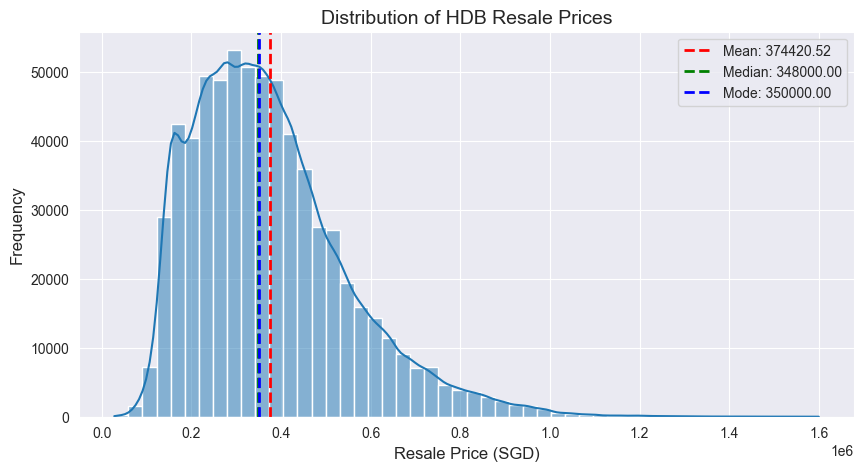

In [135]:
mean_price = merged_df["resale_price"].mean()
median_price = merged_df["resale_price"].median()
mode_price = merged_df["resale_price"].mode()[0]  # Mode can return multiple values, take first

# Create histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=merged_df, x="resale_price", bins=50, kde=True)

# Plot vertical lines for mean, median, mode
plt.axvline(mean_price, color="red", linestyle="dashed", linewidth=2, label=f"Mean: {mean_price:.2f}")
plt.axvline(median_price, color="green", linestyle="dashed", linewidth=2, label=f"Median: {median_price:.2f}")
plt.axvline(mode_price, color="blue", linestyle="dashed", linewidth=2, label=f"Mode: {mode_price:.2f}")

# Titles & Labels
plt.title("Distribution of HDB Resale Prices", fontsize=14)
plt.xlabel("Resale Price (SGD)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

In [53]:
print(f"Skewness score: {merged_df['resale_price'].skew()}")

Skewness score: 1.0570945219718373


The histogram above shows a positive skew in the resale prices, suggesting the presence of outliers in the data. Its skewness is further supported by by the skewness score when using the skew function as it provides a skew value of 1.05, indicating that there are more values to the left of the mean and a few high values pulling the mean to the right.

This is important to consider when assessing model performance and choosing the right model. Models, such as linear regression, assume that the target variable follows a normal distribution, and skewed data can affect their accuracy. Additionally, the presence of skewed data can impact visualizations like correlation plots, which usually assume that the target variable is also normally distributed. If  not addressed it could lead to a misinterpretation of our data. 

To resolve this, we can transform the target feature by applying a logarithmic function to reduce the skewness. Later on in ML we can also choose models that are not sensistive to outliers such as lasso or ridge regression

In [137]:
merged_df['log_resale_price'] = np.log(merged_df['resale_price'])
merged_df.head(1)

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,address,...,dist_mrt,near_mrt,dist_mall,near_mall,year_recorded,month_recorded,storey_lower,storey_upper,storey_middle,log_resale_price
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,69.0000000,Improved,1986,"147,000.0000000",85,170 ANG MO KIO AVE 4 SINGAPORE,...,0.5315847,YIO CHU KANG MRT STATION (NS15),0.2604689,AMK Hub,2000,1,7,9,8,11.8981879


#### Resale Price vs Flat Type and Resale Price vs Flat Model
We wanted to check if there was any relationship between the resale price and flat attributes such as type and model.

Our initial hypothesis between these three variables was that flat type would show a clear pattern in pricing, due to common knowledge that the more rooms there are, the more expensive the flat is. On the other hand, flat model would be more inconsistent, as it refers to the internal design or layout, which may not have a direct correlation with price in the same way that the number of rooms does.

To check, we decided to use box plots

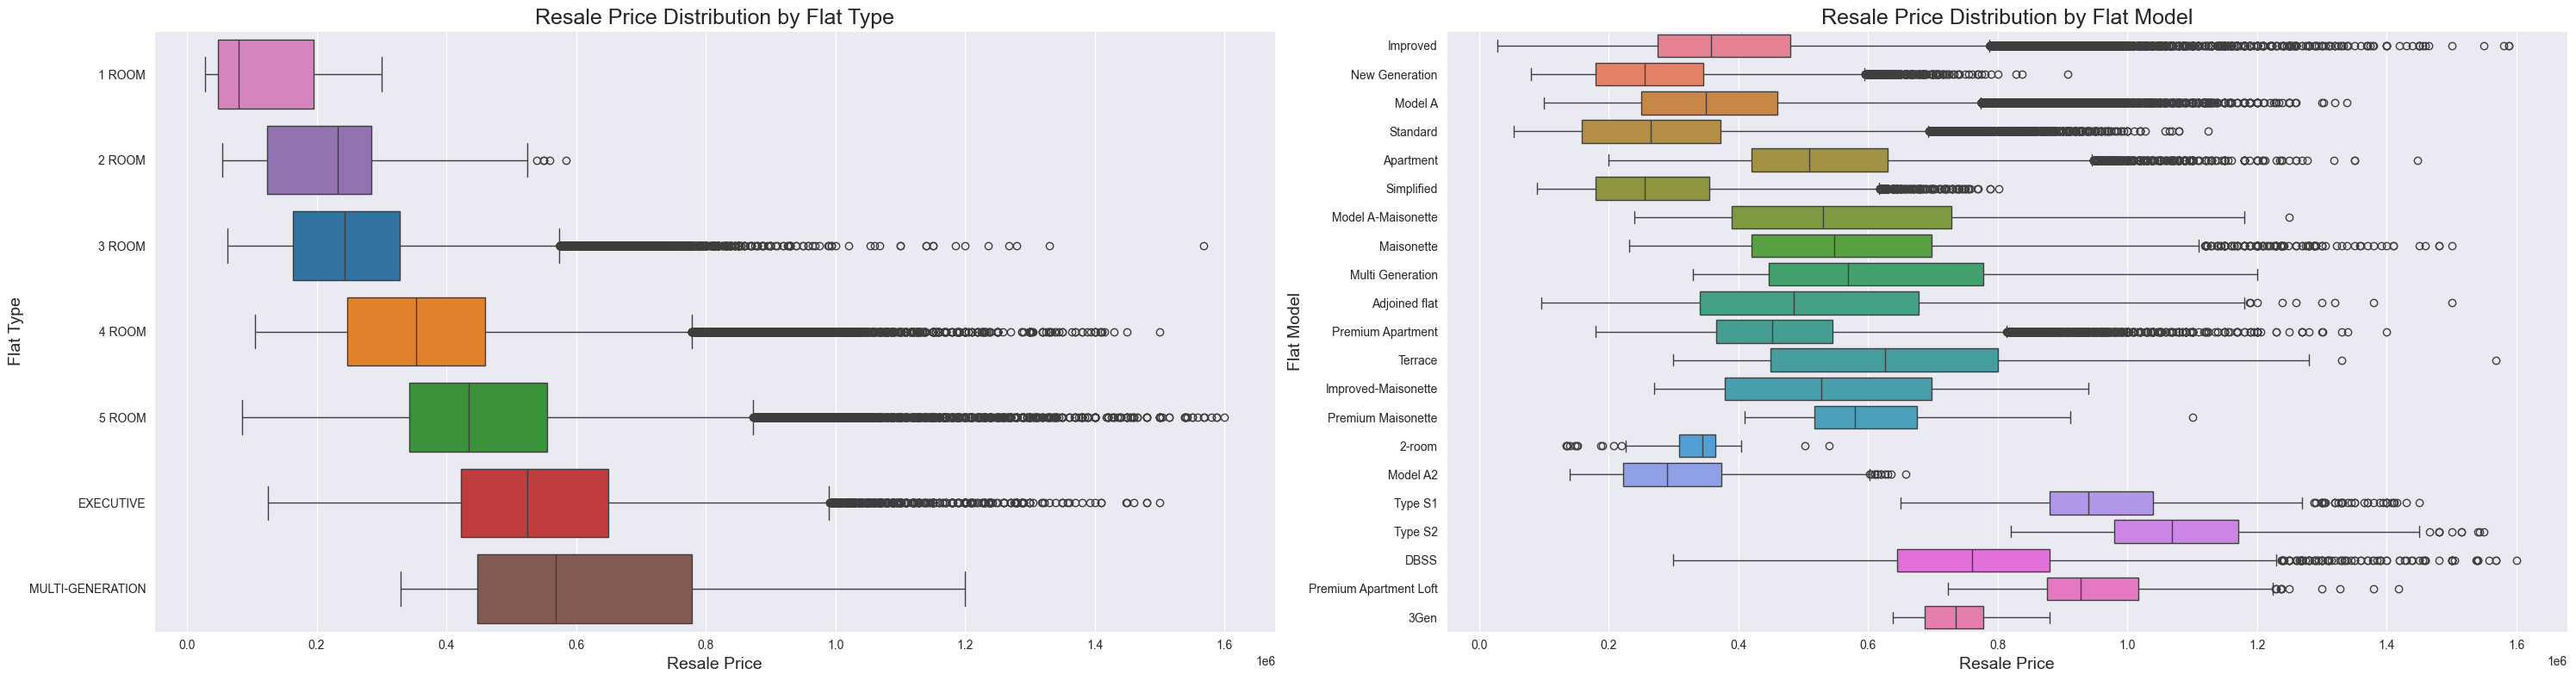

In [216]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8))

ordered_flat_types = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']

# Boxplot for resale price by flat type
sns.boxplot(data=merged_df, x='resale_price', y='flat_type', hue='flat_type', order=ordered_flat_types, ax=ax1)
ax1.set_title('Resale Price Distribution by Flat Type', fontsize=18)
ax1.set_xlabel('Resale Price', fontsize=14)
ax1.set_ylabel('Flat Type', fontsize=14)

# Boxplot for resale price by flat model
sns.boxplot(data=merged_df, x='resale_price', y='flat_model', hue='flat_model', ax=ax2)
ax2.set_title('Resale Price Distribution by Flat Model', fontsize=18)
ax2.set_xlabel('Resale Price', fontsize=14)
ax2.set_ylabel('Flat Model', fontsize=14)

plt.tight_layout()
plt.show()

From the results above, we see that :
- The resale price and flat type show a very clear positive correlation. There is a consistent upward shift in the median resale price as the number of rooms increases. This trend is evident across all flat types, including the executive and multi-generation flats. While there are several outliers, the third quartile (Q3) range also increases with the number of rooms, indicating higher prices as the size of the flat grows.
- For the flat model on the other hand, it is a lot harder to visualise any clear distinct trend as there is a lot of overlap in the price ranges. However we do see that sales price tend to be significantly higher for Type S1, Type S2, DBSS, Premium apartment loft and 3Gen housing as compared to all of the other homes.

Based on the graph alone it is not very clear on why there would be a group segregation between cetain HDB models, however after research we found that
- Type S1 and S2 are unit types at The pinnacle (Extremely expensive HDB project)
- DBSS Flats are Design, Build and Sell flats (private design homes, exclusive and rare unique designs)
- Premiumn Apartment Loft are hdb but with 2 stories with large living areas
- 3Gen housing is meant for multi generational families, boasting a signifcantly larger living space

These insights help clarify the segregation in prices, as the price differences can be attributed to the premium features, larger sizes, and recognition associated with these specific flat models.

#### Correlational Analysis

Next we wanted to take a look at the correlations between different features in our dataset and the resale price

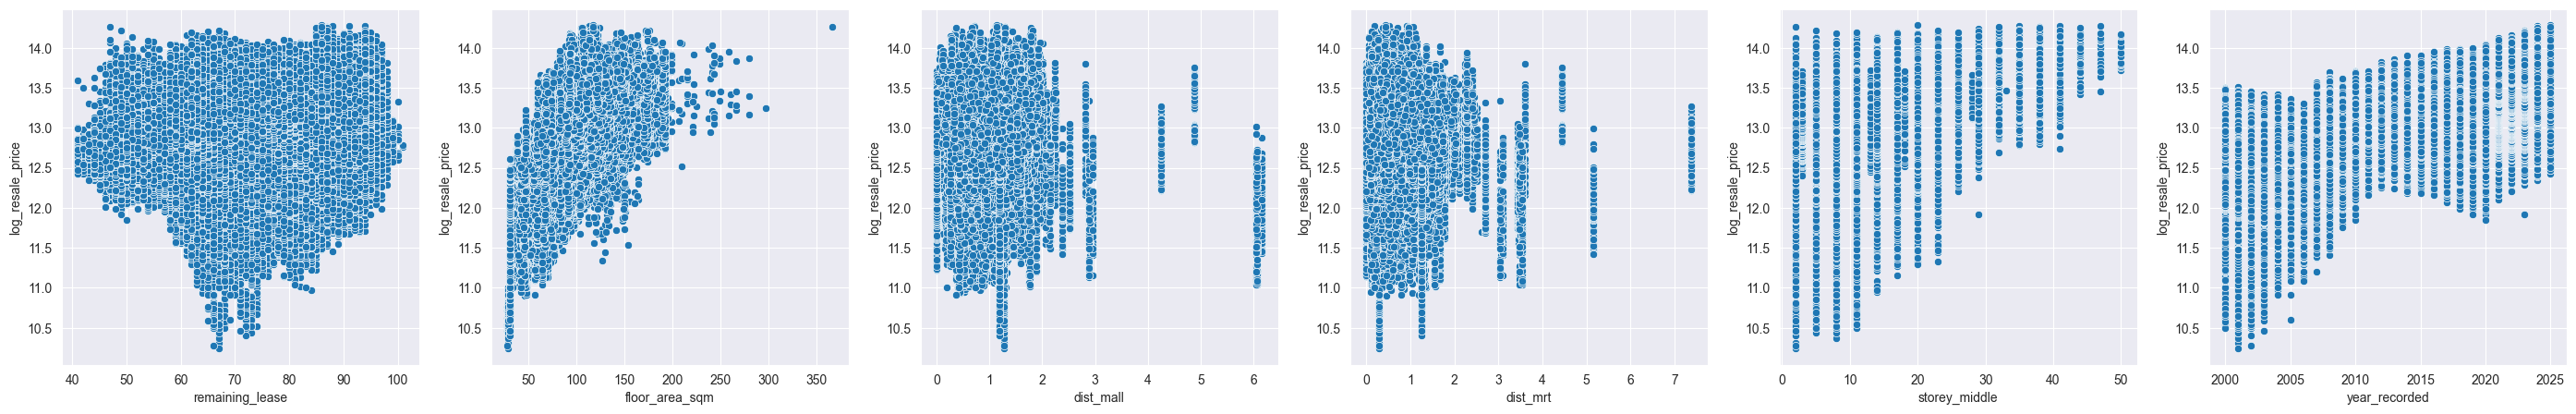

In [147]:
fig, (ax1,ax2,ax3,ax4, ax5, ax6) = plt.subplots(1,6,figsize=(35, 5))
num_ds = merged_df[['remaining_lease', 'floor_area_sqm', 'dist_mall', 'dist_mrt' , 'storey_middle','log_resale_price', 'year_recorded']]

# Create the scatter plot within the subplot

sns.scatterplot(data = num_ds, x='remaining_lease', y='log_resale_price', ax=ax1)
sns.scatterplot(data = num_ds, x='floor_area_sqm', y='log_resale_price', ax=ax2)
sns.scatterplot(data = num_ds, x='dist_mall', y='log_resale_price', ax=ax3)
sns.scatterplot(data = num_ds, x='dist_mrt', y='log_resale_price', ax=ax4)
sns.scatterplot(data = num_ds, x='storey_middle', y='log_resale_price', ax=ax5)
sns.scatterplot(data = num_ds, x='year_recorded', y='log_resale_price', ax=ax6)

# Show the plot
plt.show()

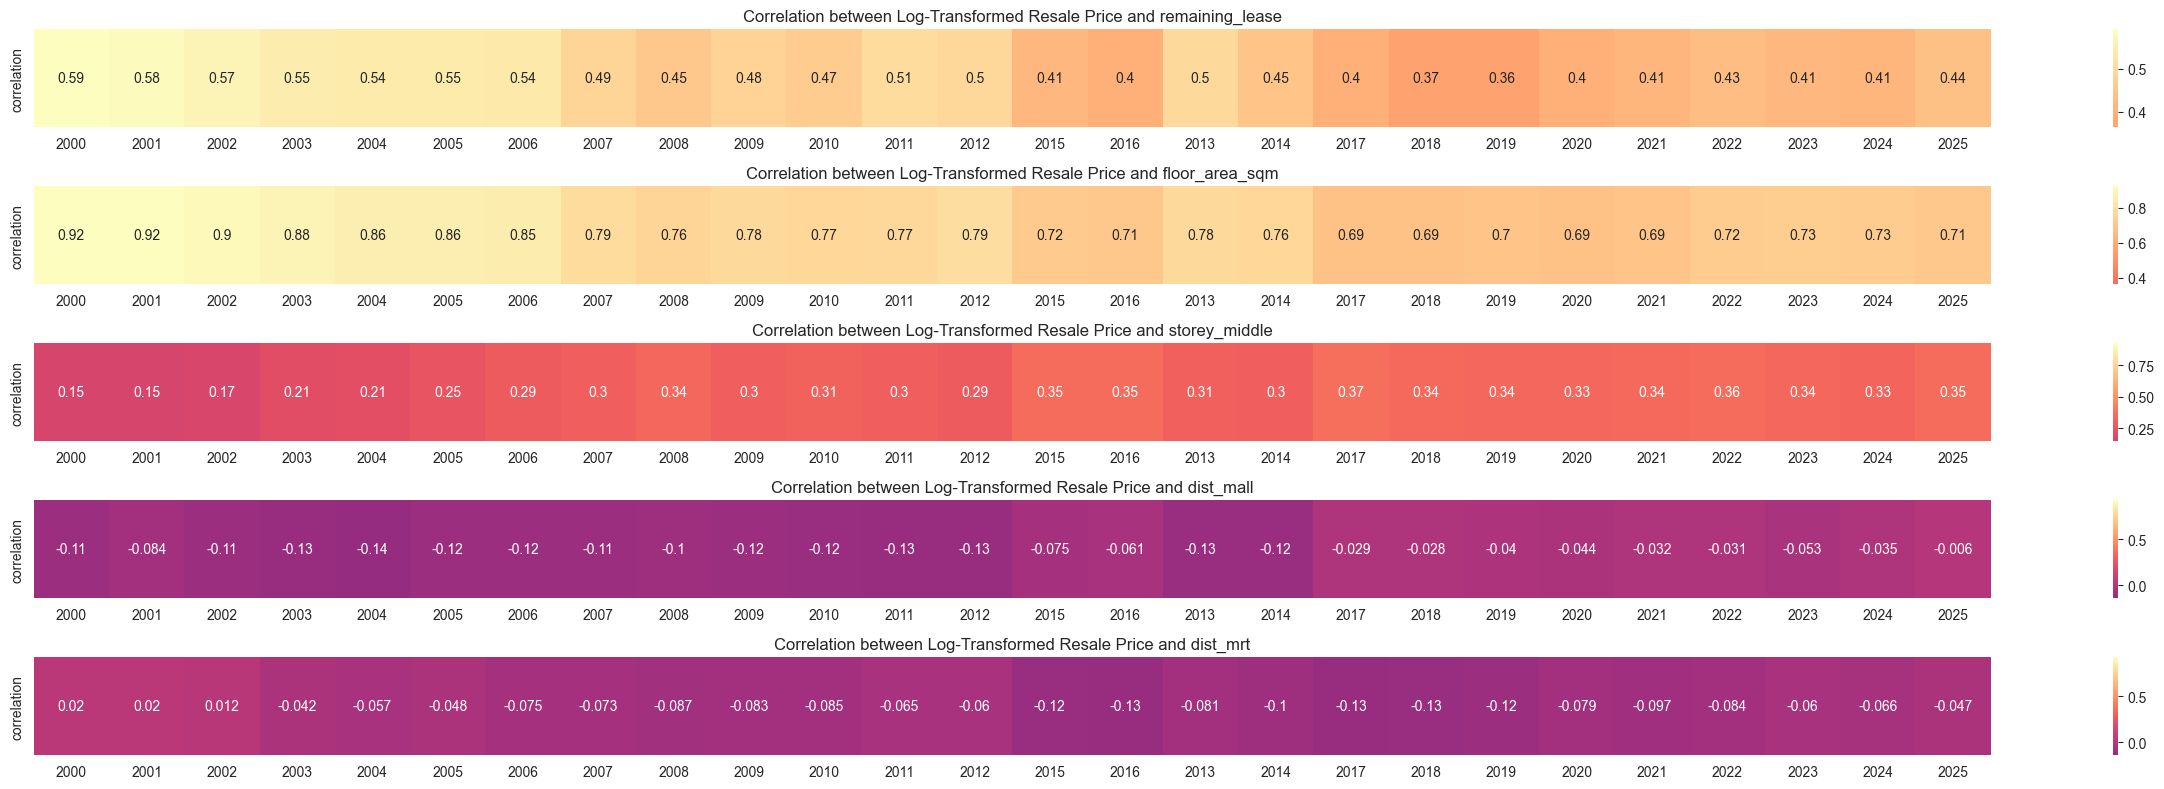

In [177]:
variables = ['remaining_lease', 'floor_area_sqm', 'storey_middle', 'dist_mall', 'dist_mrt']
fig, axes = plt.subplots(5, 1, figsize=(25, 8))
all_corr_vals = []

# Loop through each variable to generate heatmaps
for idx, var in enumerate(variables):
    heat = pd.DataFrame({'correlation': []})
    
    # Loop through each unique year and calculate the correlation
    for year in merged_df['year_recorded'].unique():
        year_df = merged_df[merged_df['year_recorded'] == year].copy()
        corr_val = year_df[['log_resale_price', var]].corr().iloc[0, 1]
        heat.loc[year] = corr_val  
    all_corr_vals.append(heat['correlation'])
    # Plot heatmap for the current variable
    sns.heatmap(heat.T, annot=True, center=0, ax=axes[idx], cmap='magma', vmin=np.min(all_corr_vals), vmax=np.max(all_corr_vals))

    axes[idx].set_title(f"Correlation between Log-Transformed Resale Price and {var}")

plt.tight_layout()
plt.show()


In [188]:
merged_df.columns

Index(['town', 'flat_type', 'block', 'street_name', 'floor_area_sqm',
       'flat_model', 'lease_commence_date', 'resale_price', 'remaining_lease',
       'address', 'latitude', 'longitude', 'dist_mrt', 'near_mrt', 'dist_mall',
       'near_mall', 'year_recorded', 'month_recorded', 'storey_lower',
       'storey_upper', 'storey_middle', 'log_resale_price'],
      dtype='object')

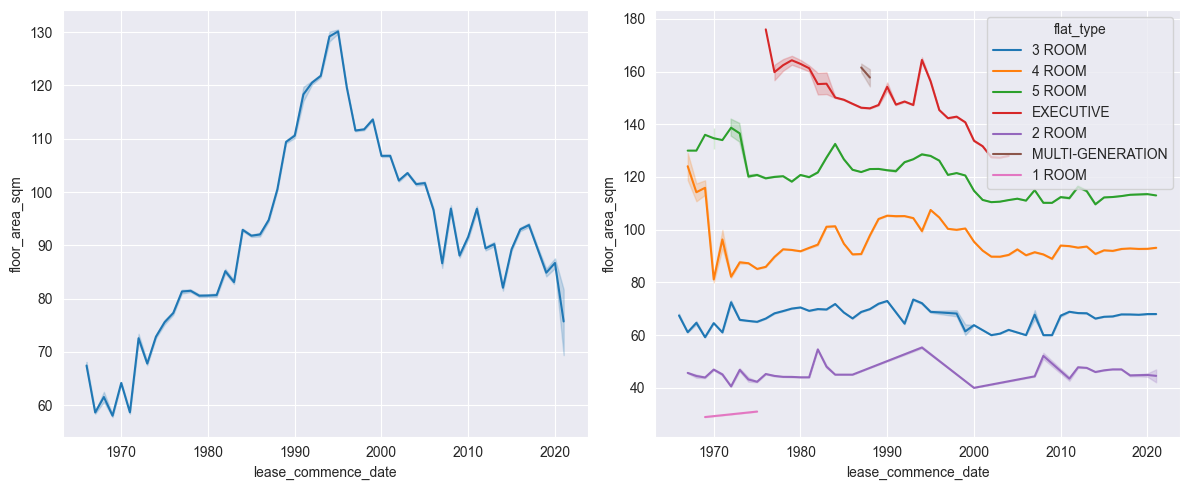

In [193]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))

sns.lineplot(data=merged_df, x='lease_commence_date', y='floor_area_sqm', ax=ax1)
sns.lineplot(data=merged_df, x='lease_commence_date', y='floor_area_sqm', ax=ax2, hue='flat_type')
plt.tight_layout()
plt.show()

In [104]:
merged_df.columns

Index(['town', 'flat_type', 'block', 'street_name', 'floor_area_sqm',
       'flat_model', 'lease_commence_date', 'resale_price', 'remaining_lease',
       'address', 'latitude', 'longitude', 'dist_mrt', 'near_mrt', 'dist_mall',
       'near_mall', 'year_recorded', 'month_recorded', 'storey_lower',
       'storey_upper', 'storey_middle', 'log_resale_price'],
      dtype='object')

Check pressence of housing establishment as year go by for different locations 

In [124]:
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded
0,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,85,2000,01
1,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,85,2000,01
2,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0,75,2000,01
3,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0,75,2000,01
4,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0,75,2000,01


### ML 

,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year_recorded,month_recorded
0,ANG MO KIO,3 ROOM,07 TO 09,69.0,Improved,1986,147000.0,85,2000,01
1,ANG MO KIO,3 ROOM,04 TO 06,61.0,Improved,1986,144000.0,85,2000,01
2,ANG MO KIO,3 ROOM,07 TO 09,73.0,New Generation,1976,159000.0,75,2000,01
3,ANG MO KIO,3 ROOM,07 TO 09,73.0,New Generation,1976,167000.0,75,2000,01
4,ANG MO KIO,3 ROOM,07 TO 09,67.0,New Generation,1976,163000.0,75,2000,01


In [152]:
ml_df = df.copy()
ml_df.drop(columns = ['block', 'street_name'], axis=1, inplace=True)
ml_df.head()
flat_type_order = {
    '1 ROOM': 1,
    '2 ROOM': 2,
    '3 ROOM': 3,
    '4 ROOM': 4,
    '5 ROOM': 5,
    'EXECUTIVE': 6,
    'MULTI-GENERATION': 7
}
ml_df['flat_type_encoded'] = ml_df['flat_type'].map(flat_type_order)
df_encoded = pd.get_dummies(ml_df, columns=['flat_model'], prefix='model', dtype=int)
df_encoded = pd.get_dummies(df_encoded, columns=['town'], prefix='town', dtype=int)
# Function to extract the middle value from a 'start TO end' range
def extract_middle(storey_range):
    try:
        start, end = storey_range.split(' TO ')
        return (int(start) + int(end)) / 2
    except:
        return None  # Handle any non-standard ranges (e.g., missing values)

# Apply the function to the 'storey_range' column
df_encoded['storey_range_middle'] = df_encoded['storey_range'].apply(extract_middle)

df_encoded.drop(['flat_type', 'lease_commence_date', 'year_recorded', 'storey_range'], axis=1, inplace = True)
df_encoded

,floor_area_sqm,resale_price,remaining_lease,month_recorded,flat_type_encoded,model_2-room,model_3Gen,model_Adjoined flat,model_Apartment,model_DBSS,...,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,storey_range_middle
0,69.0,147000.0,85,01,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
1,61.0,144000.0,85,01,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
2,73.0,159000.0,75,01,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
3,73.0,167000.0,75,01,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
4,67.0,163000.0,75,01,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201644,91.0,530000.0,66,03,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.0
201645,88.0,515000.0,61,03,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11.0
201646,122.0,725000.0,62,03,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11.0
201647,112.0,688000.0,89,03,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5.0


Train validation test

Look for AI models
-  Random forest regression 
- Ask gpt 

Metrics
- RMSE
- R2
- MAE

k fold cross val 

grid search hypertuning
